In [70]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
# for data scaling and splitting
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# for neural net
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers
# for evaluation
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# data plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
data = pd.read_csv("data/combined_expression.csv")
data['cluster'].replace([1, 2],[0, 1],inplace=True)
data.head()

,CELL_LINE_NAME,cluster,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,C6orf10,TMEM225,NOTCH4,PBX2,AGER,RNF5,AGPAT1,DFNB59,PRRT1,FKBPL
0,1240123,1,8.319417,3.111183,9.643558,4.757258,3.919757,3.602185,3.329644,9.076950,...,3.085394,3.462811,3.339030,4.614897,3.395845,3.419193,3.971646,3.729310,3.320022,6.447316
1,1240131,0,7.611268,2.704739,10.276079,3.650299,3.481567,3.145538,3.565127,7.861068,...,2.801456,2.985889,3.180068,5.415729,3.299858,3.028414,3.877889,3.911516,3.379405,4.729557
2,1240132,0,7.678658,2.845781,10.180954,3.573048,3.431235,3.090781,4.116643,8.121190,...,2.934962,2.952937,3.164655,5.707506,3.434295,2.961345,4.272194,3.085696,3.002557,5.653588
3,1240134,0,3.265063,3.063746,10.490285,3.340791,3.676912,3.512821,3.873922,8.790851,...,3.041839,3.398847,3.106710,5.773963,3.412641,3.136110,4.422262,3.522122,3.509437,5.953242
4,1240140,0,7.090138,2.988043,10.264692,4.119555,3.432585,3.308033,3.318371,6.927761,...,3.028787,3.225982,3.275820,5.334283,3.864678,3.259242,3.840581,5.809553,3.674587,5.577503


In [3]:
data.shape

(541, 16384)

In [4]:
selected_genes = pd.read_csv('cleaned/boruta.csv')
selected_genes = selected_genes.values.tolist()
selected_genes = list(itertools.chain(*selected_genes))

In [5]:
# retrieving proper columns
X = data.loc[:, selected_genes]
y = data['cluster'].values
# scaling the data
scalar = MinMaxScaler()
x_scaled = scalar.fit_transform(X)
# splitting data (20% test, 80% train)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)
sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train)

# K-Folds Evaluation Function

In [6]:
def cv_eval(model, n_folds, X, y):
    """K-fold validation function for evaluation of a Keras model.
    Arguments:
        model: the model to evaluate.
        n_folds (int): the number of cross-folds.
        X: values of the feature variables.
        y: values of the classification.
    Returns:
        cms (list): confusion matrix for each cross-fold.
        histories (list): model metrics for each cross-fold.
        tprs (list): the True Positive Rate for each cross-fold.
        base_fpr (list): the cutoff points for the ROC curve.
    """
    kf = StratifiedKFold(n_splits=n_folds)
    cms = []  # confusion matrix results
    histories = []  # for model analysis
    tprs = []  # for ROC analysis
    base_fpr = np.linspace(0, 1, 101)  # for ROC analysis

    for i_train, i_test in kf.split(X, y):
        X_train, X_test = X.iloc[i_train].values, X.iloc[i_test].values
        y_train, y_test = y[i_train], y[i_test]
        # recording model metrics and confusion matrix
        histories.append(model.fit(X_train, y_train, validation_data=(X_test, y_test)))
        cms.append(confusion_matrix(y_test, model.predict(X_test)))
        # recording for auc
        y_score = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.
        tprs.append(tpr)

    return cms, histories, tprs, base_fpr

# Confusion Matrix Plotting Function

In [45]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True, cbar=True):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(4, 3), dpi=200)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names, rotation=90, verticalalignment='center')
#         plt.yticks([], ['', ''])

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    if cbar:
        plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, misclass))
    plt.show()

    return fig

# 1 Hidden Layer

In [28]:
def hidden1(optimizer='sgd', init='normal', dropout=0.3, neurons=100):
    model = Sequential()
    # hidden layer
    model.add(Dense(neurons, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-3)
                   ))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    # output layer
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [29]:
model1 = KerasClassifier(build_fn=hidden1, epochs=25, batch_size=16)
cm_results1, history1, tpr1, base_fpr1 = cv_eval(model1, 5, X, y)

Train on 432 samples, validate on 109 samples
Epoch 1/25
432/432 [==============================] - 1s 2ms/sample - loss: 0.7194 - accuracy: 0.7454 - val_loss: 0.8583 - val_accuracy: 0.7982
Epoch 2/25
432/432 [==============================] - 0s 308us/sample - loss: 0.6080 - accuracy: 0.8171 - val_loss: 0.5574 - val_accuracy: 0.8624
Epoch 3/25
432/432 [==============================] - 0s 309us/sample - loss: 0.5972 - accuracy: 0.8194 - val_loss: 0.5704 - val_accuracy: 0.8624
Epoch 4/25
432/432 [==============================] - 0s 313us/sample - loss: 0.5979 - accuracy: 0.8171 - val_loss: 0.4749 - val_accuracy: 0.8716
Epoch 5/25
432/432 [==============================] - 0s 303us/sample - loss: 0.5324 - accuracy: 0.8565 - val_loss: 0.4263 - val_accuracy: 0.8807
Epoch 6/25
432/432 [==============================] - 0s 308us/sample - loss: 0.5241 - accuracy: 0.8588 - val_loss: 0.4346 - val_accuracy: 0.8807
Epoch 7/25
432/432 [==============================] - 0s 308us/sample - loss: 0.

Epoch 6/25
433/433 [==============================] - 0s 374us/sample - loss: 0.5051 - accuracy: 0.8707 - val_loss: 0.8075 - val_accuracy: 0.7685
Epoch 7/25
433/433 [==============================] - 0s 387us/sample - loss: 0.4954 - accuracy: 0.8545 - val_loss: 0.7363 - val_accuracy: 0.7963
Epoch 8/25
433/433 [==============================] - 0s 391us/sample - loss: 0.4707 - accuracy: 0.8707 - val_loss: 0.7306 - val_accuracy: 0.7963
Epoch 9/25
433/433 [==============================] - 0s 378us/sample - loss: 0.4596 - accuracy: 0.8753 - val_loss: 0.7478 - val_accuracy: 0.7870
Epoch 10/25
433/433 [==============================] - 0s 395us/sample - loss: 0.4301 - accuracy: 0.8845 - val_loss: 0.7390 - val_accuracy: 0.7870
Epoch 11/25
433/433 [==============================] - 0s 410us/sample - loss: 0.4603 - accuracy: 0.8730 - val_loss: 0.7145 - val_accuracy: 0.7963
Epoch 12/25
433/433 [==============================] - 0s 413us/sample - loss: 0.4449 - accuracy: 0.8868 - val_loss: 0.710

433/433 [==============================] - 0s 403us/sample - loss: 0.4933 - accuracy: 0.8776 - val_loss: 0.5477 - val_accuracy: 0.8241
Epoch 12/25
433/433 [==============================] - 0s 393us/sample - loss: 0.4636 - accuracy: 0.8707 - val_loss: 0.5123 - val_accuracy: 0.7963
Epoch 13/25
433/433 [==============================] - 0s 402us/sample - loss: 0.4751 - accuracy: 0.8684 - val_loss: 0.5250 - val_accuracy: 0.8056
Epoch 14/25
433/433 [==============================] - 0s 406us/sample - loss: 0.4769 - accuracy: 0.8868 - val_loss: 0.5029 - val_accuracy: 0.8148
Epoch 15/25
433/433 [==============================] - 0s 397us/sample - loss: 0.4562 - accuracy: 0.8799 - val_loss: 0.5870 - val_accuracy: 0.8148
Epoch 16/25
433/433 [==============================] - 0s 432us/sample - loss: 0.4745 - accuracy: 0.8730 - val_loss: 0.5291 - val_accuracy: 0.8148
Epoch 17/25
433/433 [==============================] - 0s 417us/sample - loss: 0.4451 - accuracy: 0.8753 - val_loss: 0.4844 - val_

In [30]:
cm1 = [[0, 0]]
k, l = 0, 0
for i in cm_results1:
    for j in cm_results1[0]:
        cm1[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm1 = np.array(cm1[0])

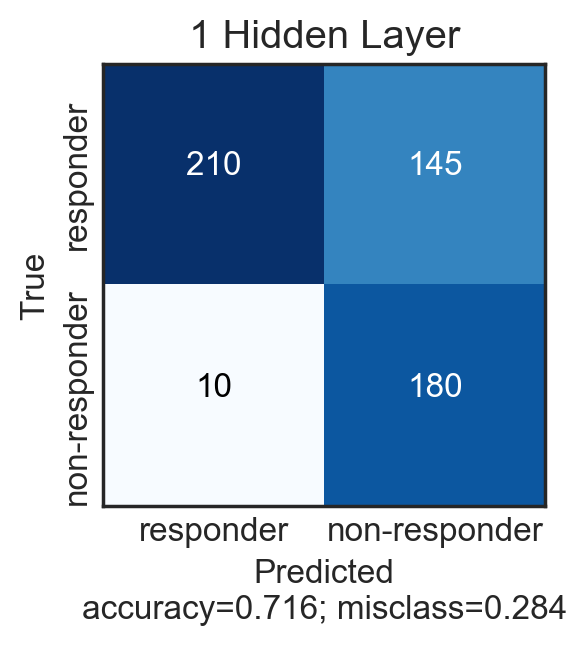

In [46]:
plt.rcParams.update({'font.size': 12})
cm_hidden1 = plot_confusion_matrix(cm1, ['responder', 'non-responder'], title='1 Hidden Layer', normalize=False, cbar=False)

# 5-Fold Validation for 5 Hidden Layers

In [12]:
def hidden5(optimizer='sgd', init='normal', dropout=0.3, neurons=100):
    model = Sequential()
    hidden_layers = len(selected_genes)
    # add 5 hidden layers
    for i in range(5):
        model.add(Dense(neurons, activation='relu',
                        kernel_regularizer=regularizers.l2(1e-3)
                       ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [13]:
model5 = KerasClassifier(build_fn=hidden5, epochs=25, batch_size=16)
cm_results5, history5, tprs5, base_fpr5 = cv_eval(model5, 5, X, y)

Train on 432 samples, validate on 109 samples
Epoch 1/25
432/432 [==============================] - 3s 6ms/sample - loss: 1.3944 - accuracy: 0.5926 - val_loss: 1.2384 - val_accuracy: 0.6422
Epoch 2/25
432/432 [==============================] - 0s 717us/sample - loss: 1.1747 - accuracy: 0.6620 - val_loss: 1.2022 - val_accuracy: 0.6514
Epoch 3/25
432/432 [==============================] - 0s 732us/sample - loss: 1.0753 - accuracy: 0.7824 - val_loss: 0.9777 - val_accuracy: 0.8532
Epoch 4/25
432/432 [==============================] - 0s 737us/sample - loss: 1.0623 - accuracy: 0.8009 - val_loss: 1.0474 - val_accuracy: 0.7982
Epoch 5/25
432/432 [==============================] - 0s 737us/sample - loss: 1.0993 - accuracy: 0.7546 - val_loss: 0.9258 - val_accuracy: 0.9083
Epoch 6/25
432/432 [==============================] - 0s 751us/sample - loss: 1.1168 - accuracy: 0.7454 - val_loss: 0.8538 - val_accuracy: 0.8807
Epoch 7/25
432/432 [==============================] - 0s 771us/sample - loss: 1.

433/433 [==============================] - 0s 1ms/sample - loss: 0.9938 - accuracy: 0.8268 - val_loss: 1.1300 - val_accuracy: 0.7593
Epoch 7/25
433/433 [==============================] - 0s 961us/sample - loss: 0.9813 - accuracy: 0.8337 - val_loss: 1.1259 - val_accuracy: 0.7778
Epoch 8/25
433/433 [==============================] - 0s 965us/sample - loss: 1.0128 - accuracy: 0.8176 - val_loss: 1.0733 - val_accuracy: 0.7963
Epoch 9/25
433/433 [==============================] - 0s 1ms/sample - loss: 0.9591 - accuracy: 0.8314 - val_loss: 1.0557 - val_accuracy: 0.8333
Epoch 10/25
433/433 [==============================] - 0s 1ms/sample - loss: 0.9462 - accuracy: 0.8337 - val_loss: 1.1522 - val_accuracy: 0.8056
Epoch 11/25
433/433 [==============================] - 0s 1ms/sample - loss: 0.9480 - accuracy: 0.8568 - val_loss: 1.1314 - val_accuracy: 0.8056
Epoch 12/25
433/433 [==============================] - 0s 1ms/sample - loss: 0.9850 - accuracy: 0.8337 - val_loss: 1.0717 - val_accuracy: 0.8

Epoch 12/25
433/433 [==============================] - 0s 1ms/sample - loss: 0.9680 - accuracy: 0.8199 - val_loss: 0.9279 - val_accuracy: 0.8611
Epoch 13/25
433/433 [==============================] - 0s 1ms/sample - loss: 1.0105 - accuracy: 0.8222 - val_loss: 0.9179 - val_accuracy: 0.8519
Epoch 14/25
433/433 [==============================] - 0s 1ms/sample - loss: 0.9645 - accuracy: 0.8337 - val_loss: 0.9357 - val_accuracy: 0.8519
Epoch 15/25
433/433 [==============================] - 0s 1ms/sample - loss: 0.9906 - accuracy: 0.8176 - val_loss: 0.9384 - val_accuracy: 0.8241
Epoch 16/25
433/433 [==============================] - 0s 1ms/sample - loss: 0.9888 - accuracy: 0.8291 - val_loss: 0.9366 - val_accuracy: 0.8426
Epoch 17/25
433/433 [==============================] - 0s 1ms/sample - loss: 0.9796 - accuracy: 0.8245 - val_loss: 0.9086 - val_accuracy: 0.8519
Epoch 18/25
433/433 [==============================] - 0s 1ms/sample - loss: 0.9842 - accuracy: 0.8245 - val_loss: 0.8930 - val_ac

In [14]:
cm5 = [[0, 0]]
k, l = 0, 0
for i in cm_results5:
    for j in cm_results5[0]:
        cm5[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm5 = np.array(cm5[0])

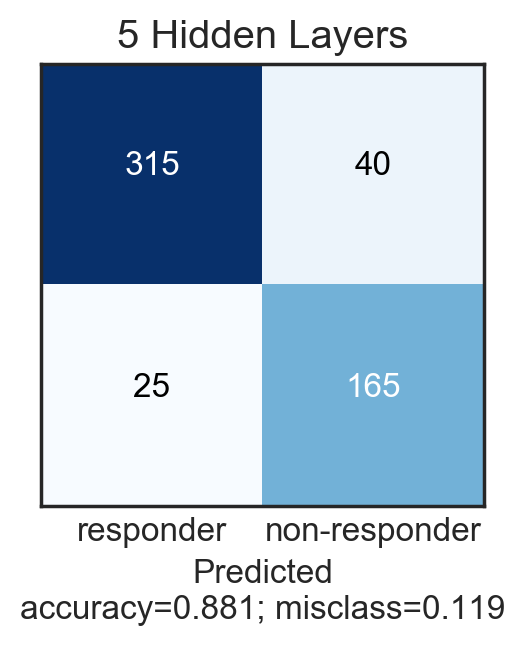

In [43]:
plt.rcParams.update({'font.size': 12})
cm_hidden5 = plot_confusion_matrix(cm5, ['responder', 'non-responder'], title='5 Hidden Layers', normalize=False, cbar=False)

# 10 Hidden Layers

In [16]:
def hidden10(optimizer='sgd', init='normal', dropout=0.3, neurons=100):
    model = Sequential()
    hidden_layers = len(selected_genes)
    # add 10 hidden layers
    for i in range(10):
        model.add(Dense(neurons, activation='relu',
                        kernel_regularizer=regularizers.l2(1e-3)
                       ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [17]:
model10 = KerasClassifier(build_fn=hidden10, epochs=25, batch_size=16)
cm_results10, history10, tprs10, base_fpr10 = cv_eval(model10, 5, X, y)

Train on 432 samples, validate on 109 samples
Epoch 1/25
432/432 [==============================] - 5s 11ms/sample - loss: 2.0155 - accuracy: 0.5324 - val_loss: 1.7352 - val_accuracy: 0.6514
Epoch 2/25
432/432 [==============================] - 1s 1ms/sample - loss: 2.0218 - accuracy: 0.5116 - val_loss: 1.8566 - val_accuracy: 0.4771
Epoch 3/25
432/432 [==============================] - 1s 1ms/sample - loss: 1.9508 - accuracy: 0.5810 - val_loss: 1.6730 - val_accuracy: 0.6514
Epoch 4/25
432/432 [==============================] - 1s 1ms/sample - loss: 1.9158 - accuracy: 0.5926 - val_loss: 1.8231 - val_accuracy: 0.6330
Epoch 5/25
432/432 [==============================] - 1s 1ms/sample - loss: 1.8886 - accuracy: 0.6157 - val_loss: 1.8449 - val_accuracy: 0.6514
Epoch 6/25
432/432 [==============================] - 1s 1ms/sample - loss: 1.8473 - accuracy: 0.6528 - val_loss: 1.8456 - val_accuracy: 0.5413
Epoch 7/25
432/432 [==============================] - 1s 1ms/sample - loss: 1.8277 - accu

Epoch 7/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.7663 - accuracy: 0.6259 - val_loss: 1.6924 - val_accuracy: 0.7407
Epoch 8/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.6863 - accuracy: 0.7136 - val_loss: 1.6078 - val_accuracy: 0.7870
Epoch 9/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.6715 - accuracy: 0.7021 - val_loss: 1.6215 - val_accuracy: 0.7685
Epoch 10/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.6785 - accuracy: 0.7182 - val_loss: 1.5834 - val_accuracy: 0.7870
Epoch 11/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.6542 - accuracy: 0.7460 - val_loss: 1.6006 - val_accuracy: 0.7963
Epoch 12/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.6317 - accuracy: 0.7321 - val_loss: 1.6108 - val_accuracy: 0.7870
Epoch 13/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.6239 - accuracy: 0.7621 - val_loss: 1.5919 - val_accur

Epoch 13/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.5618 - accuracy: 0.7691 - val_loss: 1.4812 - val_accuracy: 0.8333
Epoch 14/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.5578 - accuracy: 0.7898 - val_loss: 1.4487 - val_accuracy: 0.8333
Epoch 15/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.5235 - accuracy: 0.8199 - val_loss: 1.4891 - val_accuracy: 0.8333
Epoch 16/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.5469 - accuracy: 0.7667 - val_loss: 1.4890 - val_accuracy: 0.8426
Epoch 17/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.5675 - accuracy: 0.7991 - val_loss: 1.5056 - val_accuracy: 0.8426
Epoch 18/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.5533 - accuracy: 0.7921 - val_loss: 1.4992 - val_accuracy: 0.8333
Epoch 19/25
433/433 [==============================] - 1s 2ms/sample - loss: 1.5731 - accuracy: 0.8083 - val_loss: 1.5276 - val_ac

In [18]:
cm10 = [[0, 0]]
k, l = 0, 0
for i in cm_results10:
    for j in cm_results10[0]:
        cm10[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm10 = np.array(cm10[0])
cm10

array([[355,   0],
       [ 50, 140]])

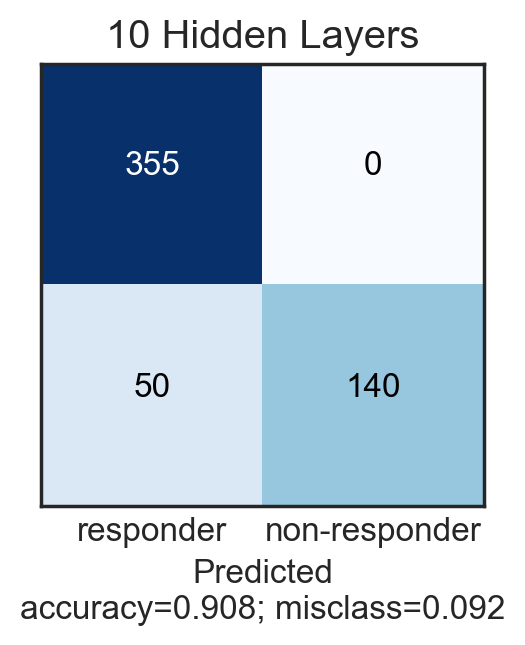

In [42]:
plt.rcParams.update({'font.size': 12})
cm_hidden10 = plot_confusion_matrix(cm10, ['responder', 'non-responder'], title='10 Hidden Layers', normalize=False, cbar=False)

# 15 Hidden Layers

In [20]:
def hidden15(optimizer='sgd', init='normal', dropout=0.3, neurons=100):
    model = Sequential()
    hidden_layers = len(selected_genes)
    # add 15 hidden layers
    for i in range(15):
        model.add(Dense(neurons, activation='relu',
                        kernel_regularizer=regularizers.l2(1e-3)
                       ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [21]:
model15 = KerasClassifier(build_fn=hidden15, epochs=25, batch_size=16)
cm_results15, history15, tprs15, base_fpr15 = cv_eval(model15, 5, X, y)

Train on 432 samples, validate on 109 samples
Epoch 1/25
432/432 [==============================] - 8s 19ms/sample - loss: 2.7218 - accuracy: 0.5023 - val_loss: 2.7393 - val_accuracy: 0.3486
Epoch 2/25
432/432 [==============================] - 1s 2ms/sample - loss: 2.7593 - accuracy: 0.5394 - val_loss: 2.5708 - val_accuracy: 0.6514
Epoch 3/25
432/432 [==============================] - 1s 2ms/sample - loss: 2.7570 - accuracy: 0.4954 - val_loss: 2.7541 - val_accuracy: 0.0917
Epoch 4/25
432/432 [==============================] - 1s 2ms/sample - loss: 2.6792 - accuracy: 0.5463 - val_loss: 2.5723 - val_accuracy: 0.6514
Epoch 5/25
432/432 [==============================] - 1s 2ms/sample - loss: 2.6841 - accuracy: 0.5440 - val_loss: 3.7063 - val_accuracy: 0.1101
Epoch 6/25
432/432 [==============================] - 1s 2ms/sample - loss: 2.6389 - accuracy: 0.5903 - val_loss: 3.7799 - val_accuracy: 0.0734
Epoch 7/25
432/432 [==============================] - 1s 2ms/sample - loss: 2.6270 - accu

Epoch 7/25
433/433 [==============================] - 1s 3ms/sample - loss: 2.4510 - accuracy: 0.5751 - val_loss: 2.3335 - val_accuracy: 0.6481
Epoch 8/25
433/433 [==============================] - 1s 3ms/sample - loss: 2.4698 - accuracy: 0.5774 - val_loss: 2.3224 - val_accuracy: 0.6481
Epoch 9/25
433/433 [==============================] - 1s 3ms/sample - loss: 2.4534 - accuracy: 0.5566 - val_loss: 2.2861 - val_accuracy: 0.6481
Epoch 10/25
433/433 [==============================] - 1s 3ms/sample - loss: 2.4085 - accuracy: 0.6351 - val_loss: 2.3173 - val_accuracy: 0.6574
Epoch 11/25
433/433 [==============================] - 1s 3ms/sample - loss: 2.3835 - accuracy: 0.6259 - val_loss: 2.2953 - val_accuracy: 0.7222
Epoch 12/25
433/433 [==============================] - 1s 3ms/sample - loss: 2.3715 - accuracy: 0.6120 - val_loss: 2.2592 - val_accuracy: 0.7500
Epoch 13/25
433/433 [==============================] - 1s 3ms/sample - loss: 2.4070 - accuracy: 0.5843 - val_loss: 2.2789 - val_accur

Epoch 13/25
433/433 [==============================] - 1s 3ms/sample - loss: 2.3272 - accuracy: 0.6351 - val_loss: 2.2590 - val_accuracy: 0.7685
Epoch 14/25
433/433 [==============================] - 1s 3ms/sample - loss: 2.3363 - accuracy: 0.6305 - val_loss: 2.2124 - val_accuracy: 0.7685
Epoch 15/25
433/433 [==============================] - 1s 3ms/sample - loss: 2.3141 - accuracy: 0.6582 - val_loss: 2.1748 - val_accuracy: 0.7778
Epoch 16/25
433/433 [==============================] - 1s 3ms/sample - loss: 2.2973 - accuracy: 0.6859 - val_loss: 2.1937 - val_accuracy: 0.7593
Epoch 17/25
433/433 [==============================] - 1s 3ms/sample - loss: 2.2869 - accuracy: 0.6859 - val_loss: 2.1971 - val_accuracy: 0.7407
Epoch 18/25
433/433 [==============================] - 1s 3ms/sample - loss: 2.2973 - accuracy: 0.6790 - val_loss: 2.2079 - val_accuracy: 0.7500
Epoch 19/25
433/433 [==============================] - 1s 3ms/sample - loss: 2.2885 - accuracy: 0.6975 - val_loss: 2.1774 - val_ac

In [22]:
cm15 = [[0, 0]]
k, l = 0, 0
for i in cm_results15:
    for j in cm_results15[0]:
        cm15[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm15 = np.array(cm15[0])
cm15

array([[355,   0],
       [ 80, 110]])

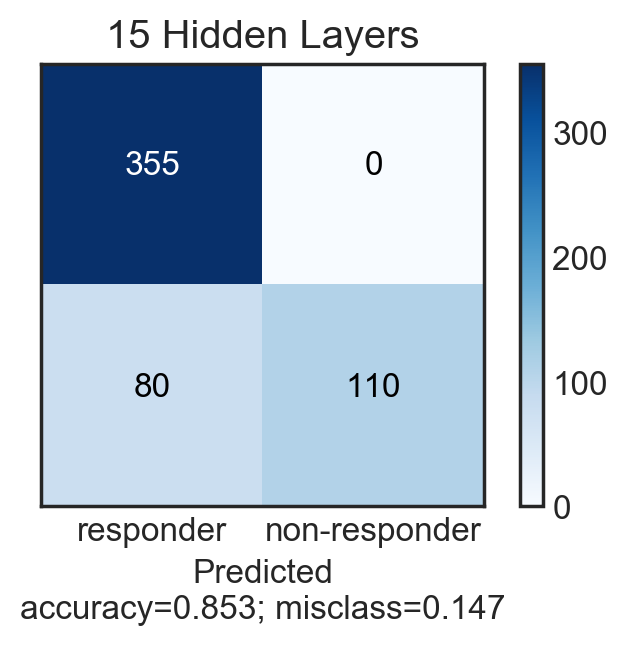

In [40]:
plt.rcParams.update({'font.size': 12})
cm_hidden15 = plot_confusion_matrix(cm15, ['responder', 'non-responder'], title='15 Hidden Layers', normalize=False)

# Comparison Plots

In [24]:
# for 1 hidden layer
tprs1 = np.array(tpr1)
mean_tprs1 = tprs1.mean(axis=0)
std1 = tprs1.std(axis=0)
tprs_upper1 = mean_tprs1 + std1 / np.sqrt(5)
tprs_lower1 = mean_tprs1 - std1 / np.sqrt(5)
auc1 = auc(base_fpr1, mean_tprs1)

In [25]:
# for 5 hidden layers
tprs5 = np.array(tprs5)
mean_tprs5 = tprs5.mean(axis=0)
std5 = tprs5.std(axis=0)
tprs_upper5 = mean_tprs5 + std5 / np.sqrt(5)
tprs_lower5 = mean_tprs5 - std5 / np.sqrt(5)
auc5 = auc(base_fpr5, mean_tprs5)

In [56]:
# for 10 hidden layers
tprs10 = np.array(tprs10)
mean_tprs10 = tprs10.mean(axis=0)
std10 = tprs10.std(axis=0)
tprs_upper10 = mean_tprs10 + std10 / np.sqrt(5)
tprs_lower10 = mean_tprs10 - std10 / np.sqrt(5)
auc10 = auc(base_fpr10, mean_tprs10)

In [57]:
# for 15 hidden layers
tprs15 = np.array(tprs15)
mean_tprs15 = tprs15.mean(axis=0)
std15 = tprs15.std(axis=0)
tprs_upper15 = mean_tprs15 + std15 / np.sqrt(5)
tprs_lower15 = mean_tprs15 - std15 / np.sqrt(5)
auc15 = auc(base_fpr15, mean_tprs15)

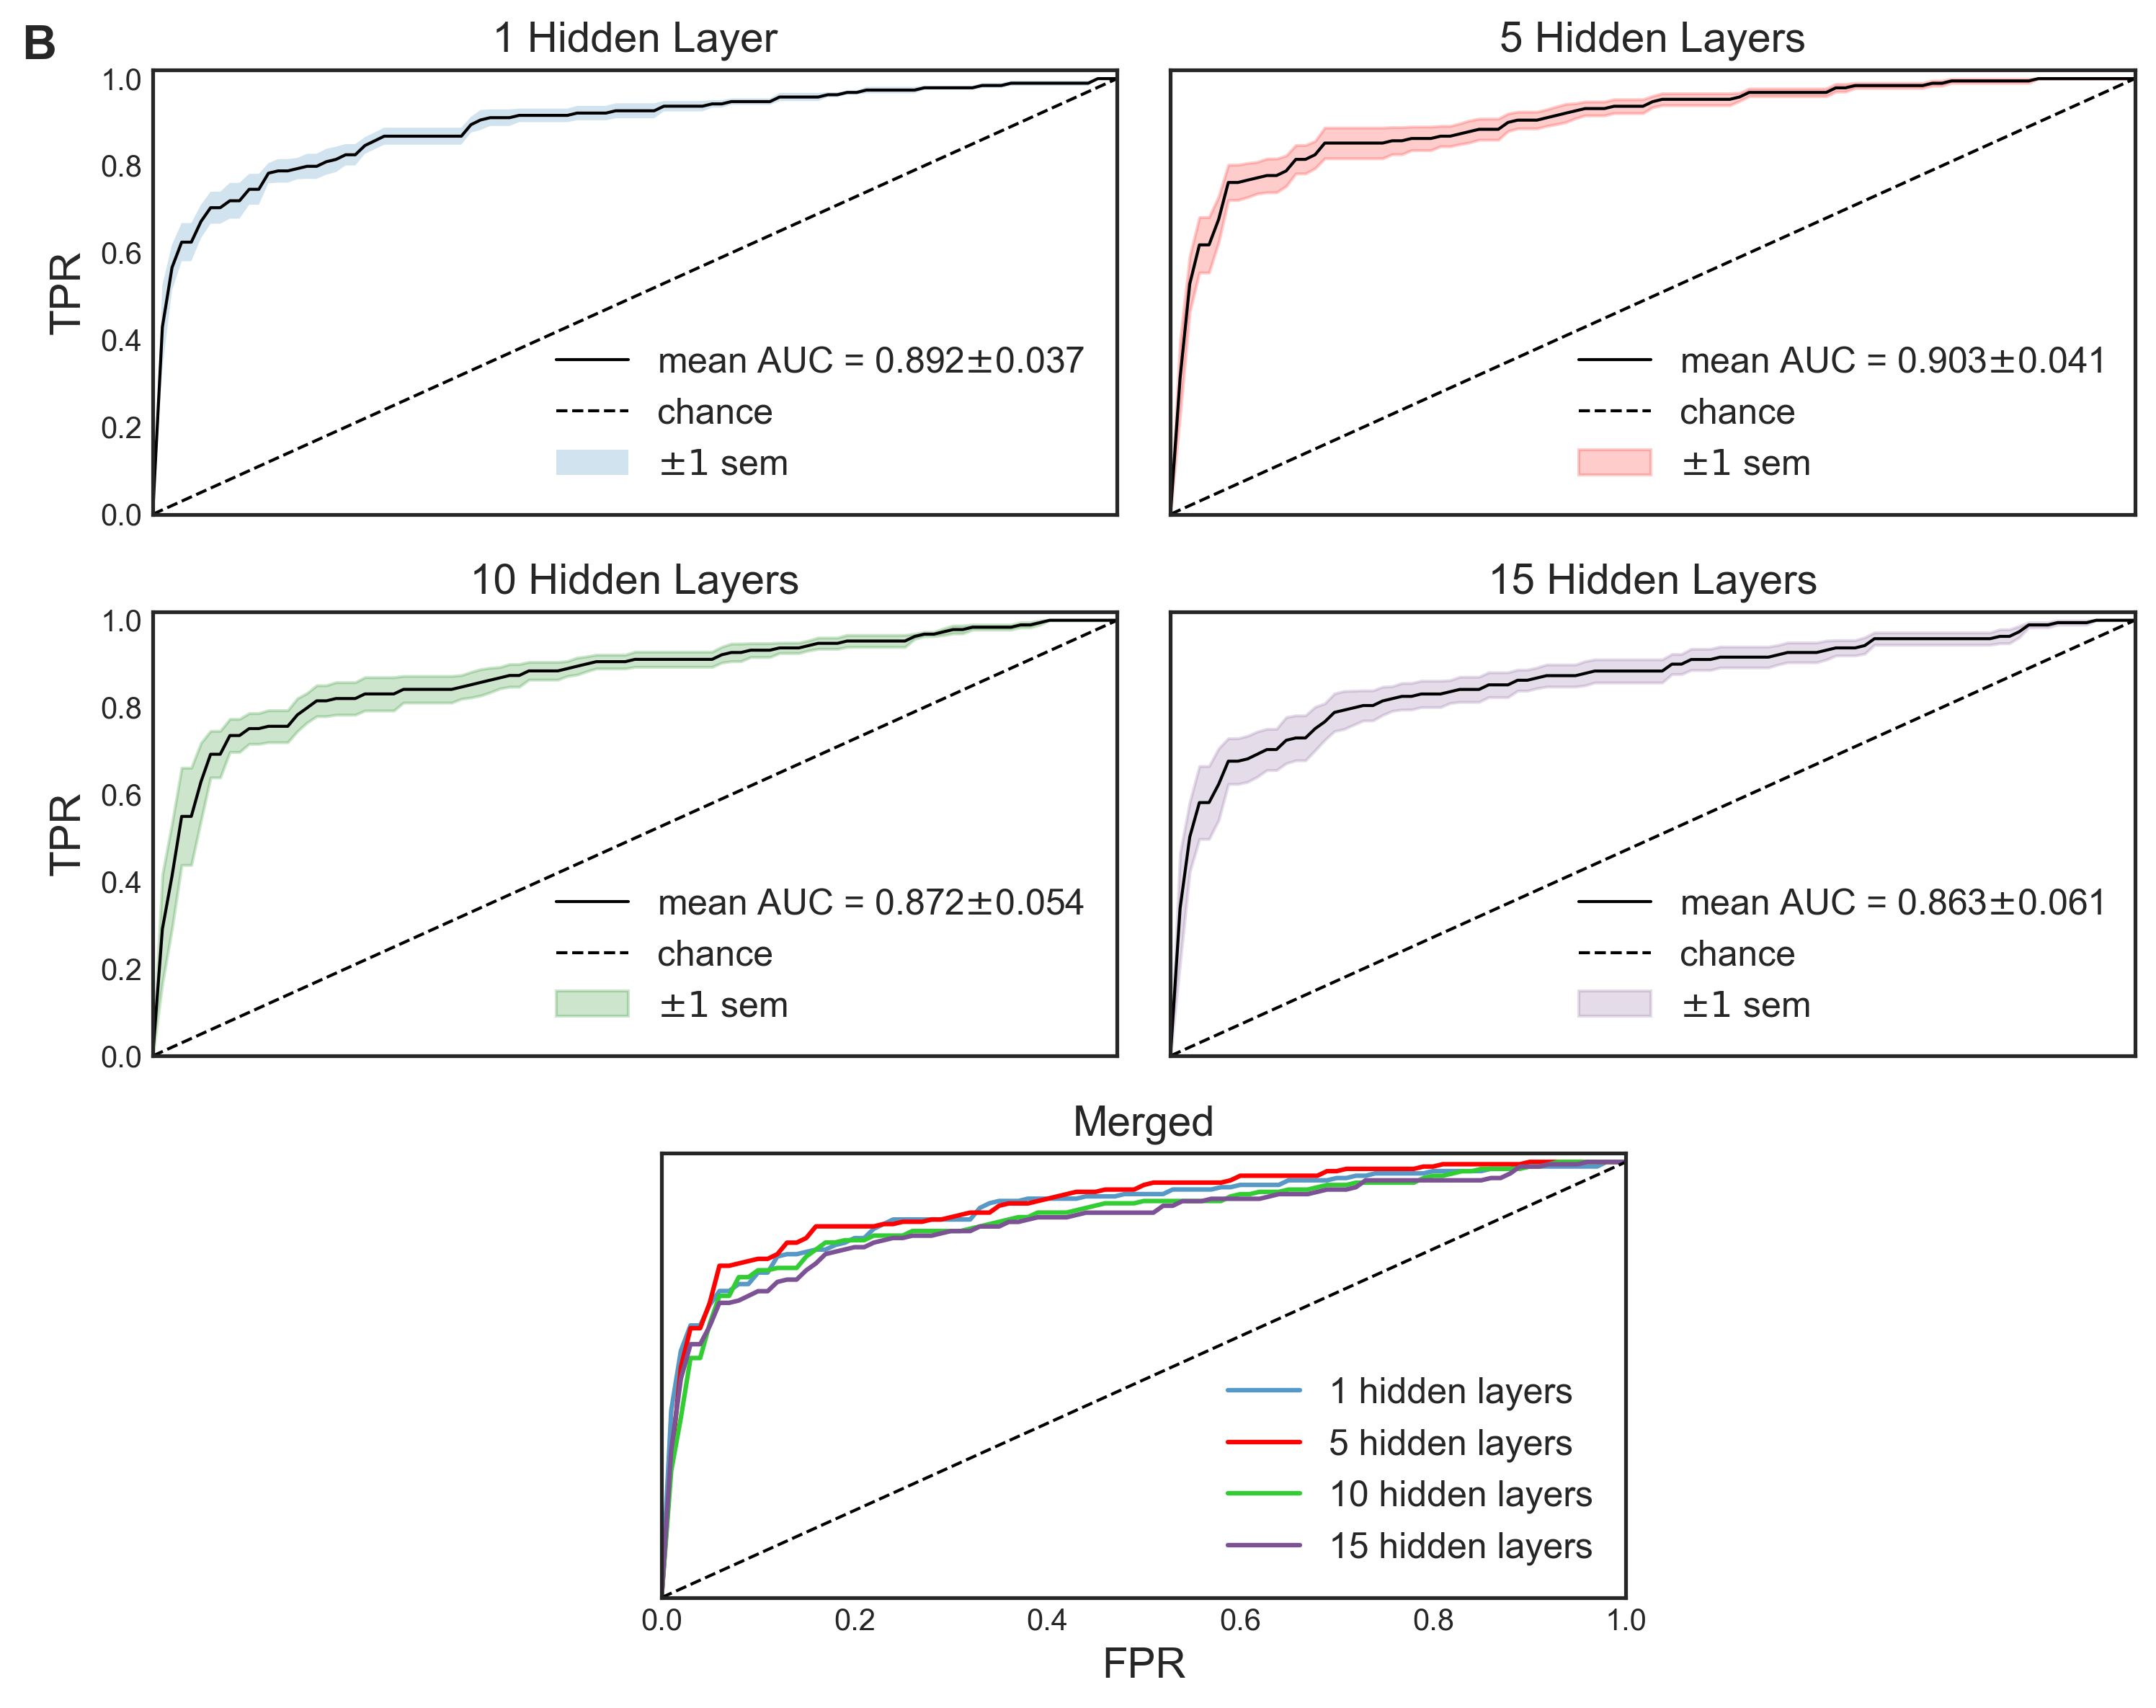

In [96]:
plt.style.use('seaborn-white')

plt.rcParams.update({'font.size': 10})
# combined figure
fig = plt.figure(figsize=(10,8), dpi=300)
spec = gridspec.GridSpec(ncols=4, nrows=3, figure=fig)
ax1 = fig.add_subplot(spec[0, :2])
ax2 = fig.add_subplot(spec[0, 2:])
ax3 = fig.add_subplot(spec[1, :2])
ax4 = fig.add_subplot(spec[1, 2:])
ax5 = fig.add_subplot(spec[2, 1:3])

# 1 hidden layer
ax1.plot(base_fpr1, mean_tprs1, 'k', linewidth=1)
ax1.fill_between(base_fpr1, tprs_lower1, tprs_upper1, alpha=0.2)
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1.02])
ax1.set_title('1 Hidden Layer', fontsize=14)
ax1.set_ylabel('TPR', fontsize=14)
ax1.set_xlabel('FPR', fontsize=14)
ax1.legend(['mean AUC = ' + str(round(auc1, 3)) + '$\pm$' + str(round(np.mean(std1), 3)),
            'chance', '$\pm 1$ sem'],
           fontsize=12, loc='lower right')
ax1.text(-.1, 1.1, 'B', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# 5 hidden layers
ax2.plot(base_fpr5, mean_tprs5, color='k', linewidth=1)
ax2.fill_between(base_fpr5, tprs_lower5, tprs_upper5, alpha=0.2, color='r')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1.02])
ax2.set_title('5 Hidden Layers', fontsize=14)
ax2.set_ylabel('TPR', fontsize=14)
ax2.set_xlabel('FPR', fontsize=14)
ax2.legend(['mean AUC = ' + str(round(auc5, 3)) + '$\pm$' + str(round(np.mean(std5), 3)),
            'chance', '$\pm 1$ sem'],
           fontsize=12, loc='lower right')

# 10 hidden layers
ax3.plot(base_fpr10, mean_tprs10, color='k', linewidth=1)
ax3.fill_between(base_fpr10, tprs_lower10, tprs_upper10, alpha=0.2, color='g')
ax3.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1.02])
ax3.set_title('10 Hidden Layers', fontsize=14)
ax3.set_ylabel('TPR', fontsize=14)
ax3.set_xlabel('FPR', fontsize=14)
ax3.legend(['mean AUC = ' + str(round(auc10, 3)) + '$\pm$' + str(round(np.mean(std10), 3)),
            'chance', '$\pm 1$ sem'],
           fontsize=12, loc='lower right')

# 15 hidden layers
ax4.plot(base_fpr15, mean_tprs15, color='k', linewidth=1)
ax4.fill_between(base_fpr15, tprs_lower15, tprs_upper15, alpha=0.2, color='#7c5295')
ax4.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax4.set_xlim([0, 1])
ax4.set_ylim([0, 1.02])
ax4.set_title('15 Hidden Layers', fontsize=14)
ax4.set_ylabel('TPR', fontsize=14)
ax4.set_xlabel('FPR', fontsize=14)
ax4.legend(['mean AUC = ' + str(round(auc15, 3)) + '$\pm$' + str(round(np.mean(std15), 3)),
            'chance', '$\pm 1$ sem'],
           fontsize=12, loc='lower right')

# merged
## 1
ax5.plot(base_fpr1, mean_tprs1, linewidth=1.5, alpha=0.75)
# ax5.fill_between(base_fpr1, tprs_lower1, tprs_upper1, alpha=0.2)
## 5
ax5.plot(base_fpr5, mean_tprs5, '#ff0000', linewidth=1.5, alpha=1)
# ax5.fill_between(base_fpr5, tprs_lower5, tprs_upper5, alpha=0.2, color='r')
## 10
ax5.plot(base_fpr10, mean_tprs10, '#32CD32', linewidth=1.5, alpha=1)
# ax5.fill_between(base_fpr10, tprs_lower10, tprs_upper10, alpha=0.2, color='g')
## 15
ax5.plot(base_fpr15, mean_tprs15, '#7c5295', linewidth=1.5, alpha=1)
# ax5.fill_between(base_fpr15, tprs_lower15, tprs_upper15, alpha=0.2, color='#7c5295')

# overall graph
ax5.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax5.set_xlim([0, 1])
ax5.set_ylim([0, 1.02])
ax5.set_title('Merged', fontsize=14)
ax5.set_ylabel('TPR', fontsize=14)
ax5.set_xlabel('FPR', fontsize=14)
ax5.legend(['1 hidden layers', '5 hidden layers', '10 hidden layers', '15 hidden layers'], fontsize=12, loc='lower right')

for ax in fig.get_axes():
    ax.label_outer()
fig.tight_layout()

In [97]:
fig.savefig('figures/roc_combined.png')